In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

%matplotlib inline

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['figure.figsize'] = (10, 5)
sns.set(style="white")

# Проектная работа по модулю "Препроцессинг данных"

#### 1. Загрузить файл data_breast.csv. В данном файле собрана расчетная информация с обработанных изображений биоптата молочных желез женщин. Задача заключается в предсказании переменной "Diagnosis" - являктся ли содержимое биоптата доброкачественным (значение "B" - benign) либо злокачественным (значение "М" - malicious). Описание данных доступно на сайте: https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29

In [2]:
df = pd.read_csv('data_breast.csv')
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [3]:
df['diagnosis'] = df['diagnosis'].apply(lambda x: (1 if x is 'M' else 0) if x is 'M' or x is 'B' else x) # Обрабатываем предиктор

df['concave_points_worst'] = df['concave points_worst']
df['concave_points_mean'] = df['concave points_mean']
df['concave_points_se'] = df['concave points_se']
df = df.drop('concave points_worst', axis=1)
df = df.drop('concave points_mean', axis=1)
df = df.drop('concave points_se', axis=1)

#### 2.Рассчитать основные статистики для переменных (среднее, медиана, мода, мин/макс, сред. отклонение).

In [4]:
df.describe()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,symmetry_mean,...,area_worst,smoothness_worst,compactness_worst,concavity_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32,concave_points_worst,concave_points_mean,concave_points_se
count,5.690000e+02,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,0.0,569.000000,569.000000,569.000000
mean,3.037183e+07,0.372583,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.181162,...,880.583128,0.132369,0.254265,0.272188,0.290076,0.083946,NaN,0.114606,0.048919,0.011796
std,1.250206e+08,0.483918,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.027414,...,569.356993,0.022832,0.157336,0.208624,0.061867,0.018061,NaN,0.065732,0.038803,0.006170
min,8.670000e+03,0.000000,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.106000,...,185.200000,0.071170,0.027290,0.000000,0.156500,0.055040,NaN,0.000000,0.000000,0.000000
25%,8.692180e+05,0.000000,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.161900,...,515.300000,0.116600,0.147200,0.114500,0.250400,0.071460,NaN,0.064930,0.020310,0.007638
50%,9.060240e+05,0.000000,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.179200,...,686.500000,0.131300,0.211900,0.226700,0.282200,0.080040,NaN,0.099930,0.033500,0.010930
75%,8.813129e+06,1.000000,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.195700,...,1084.000000,0.146000,0.339100,0.382900,0.317900,0.092080,NaN,0.161400,0.074000,0.014710
max,9.113205e+08,1.000000,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.304000,...,4254.000000,0.222600,1.058000,1.252000,0.663800,0.207500,NaN,0.291000,0.201200,0.052790


#### 3. Выбрать стратегию для работы с пропущенными значениями

In [5]:
df.info() # Пропущенная колонка - "Unnamed: 32". дропаем ее

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
id                         569 non-null int64
diagnosis                  569 non-null int64
radius_mean                569 non-null float64
texture_mean               569 non-null float64
perimeter_mean             569 non-null float64
area_mean                  569 non-null float64
smoothness_mean            569 non-null float64
compactness_mean           569 non-null float64
concavity_mean             569 non-null float64
symmetry_mean              569 non-null float64
fractal_dimension_mean     569 non-null float64
radius_se                  569 non-null float64
texture_se                 569 non-null float64
perimeter_se               569 non-null float64
area_se                    569 non-null float64
smoothness_se              569 non-null float64
compactness_se             569 non-null float64
concavity_se               569 non-null float64
symmetry_se                569 non-

In [6]:
df = df.dropna(axis='columns')

#### 4. Рассчитать и визуализировать корреляционную матрицу для переменных.

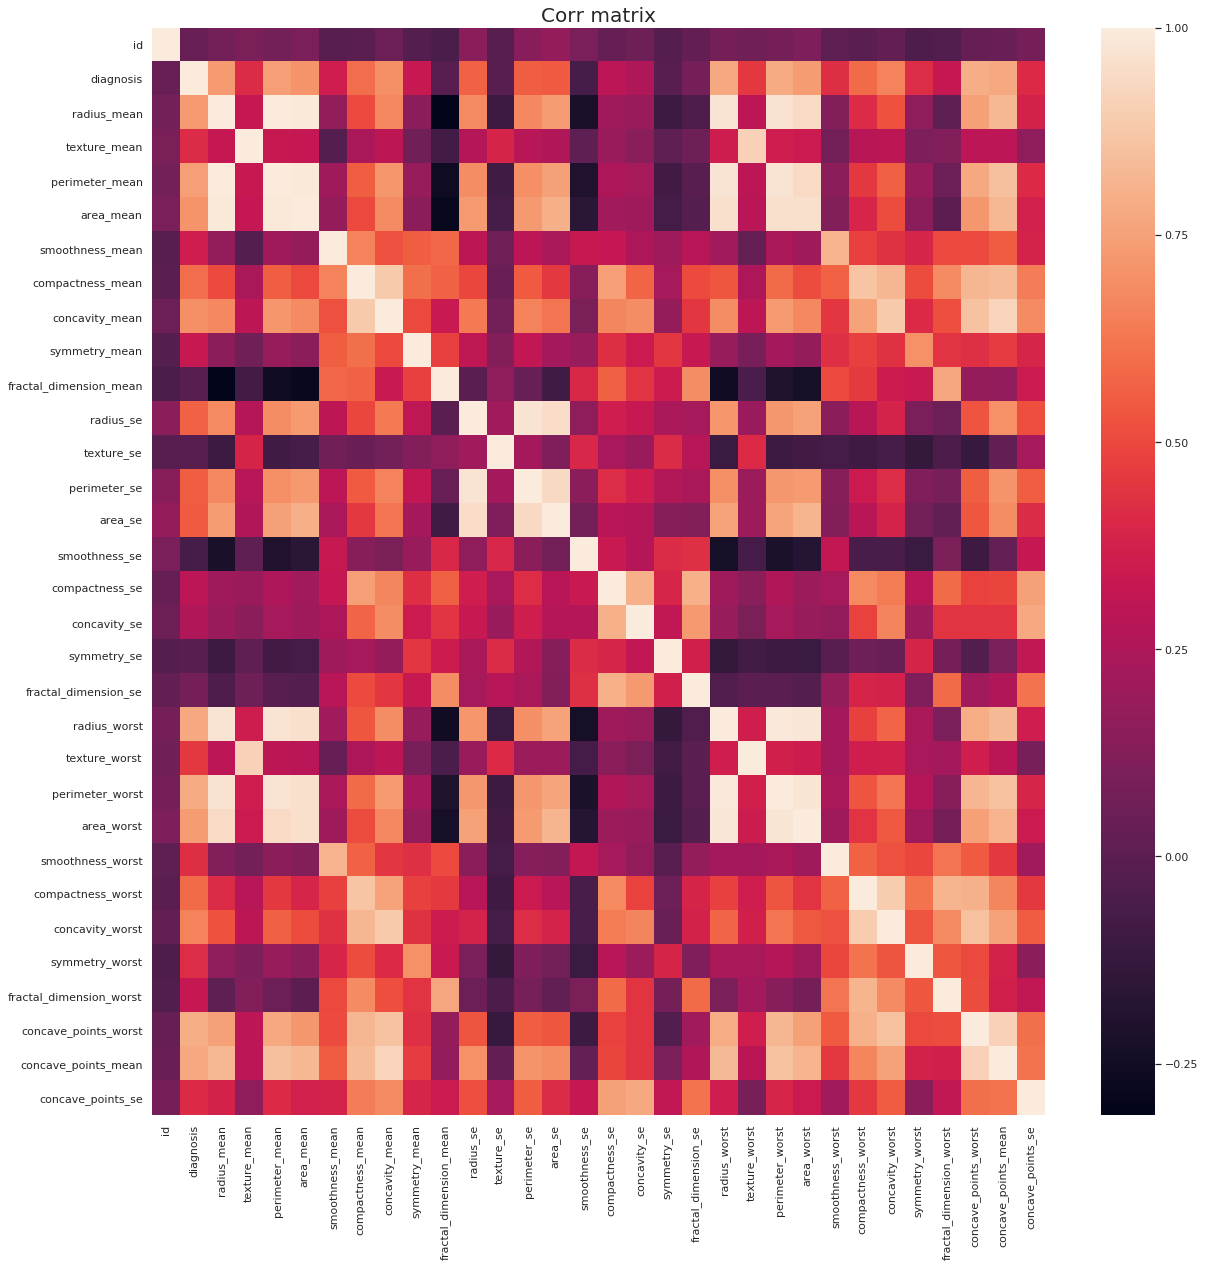

In [7]:
corr = df.corr()
fig, ax = plt.subplots(figsize=(20,20))
plt.title('Corr matrix', size=20)
sns.heatmap(
    corr, 
    xticklabels=corr.columns.values,
    yticklabels=corr.columns.values,
    ax=ax,
)
plt.show()

In [8]:
corr['diagnosis'].abs().sort_values(ascending=False)

diagnosis                  1.000000
concave_points_worst       0.793566
perimeter_worst            0.782914
concave_points_mean        0.776614
radius_worst               0.776454
perimeter_mean             0.742636
area_worst                 0.733825
radius_mean                0.730029
area_mean                  0.708984
concavity_mean             0.696360
concavity_worst            0.659610
compactness_mean           0.596534
compactness_worst          0.590998
radius_se                  0.567134
perimeter_se               0.556141
area_se                    0.548236
texture_worst              0.456903
smoothness_worst           0.421465
symmetry_worst             0.416294
texture_mean               0.415185
concave_points_se          0.408042
smoothness_mean            0.358560
symmetry_mean              0.330499
fractal_dimension_worst    0.323872
compactness_se             0.292999
concavity_se               0.253730
fractal_dimension_se       0.077972
smoothness_se              0

#### 5. Визуализировать взаимосвязи между переменными.

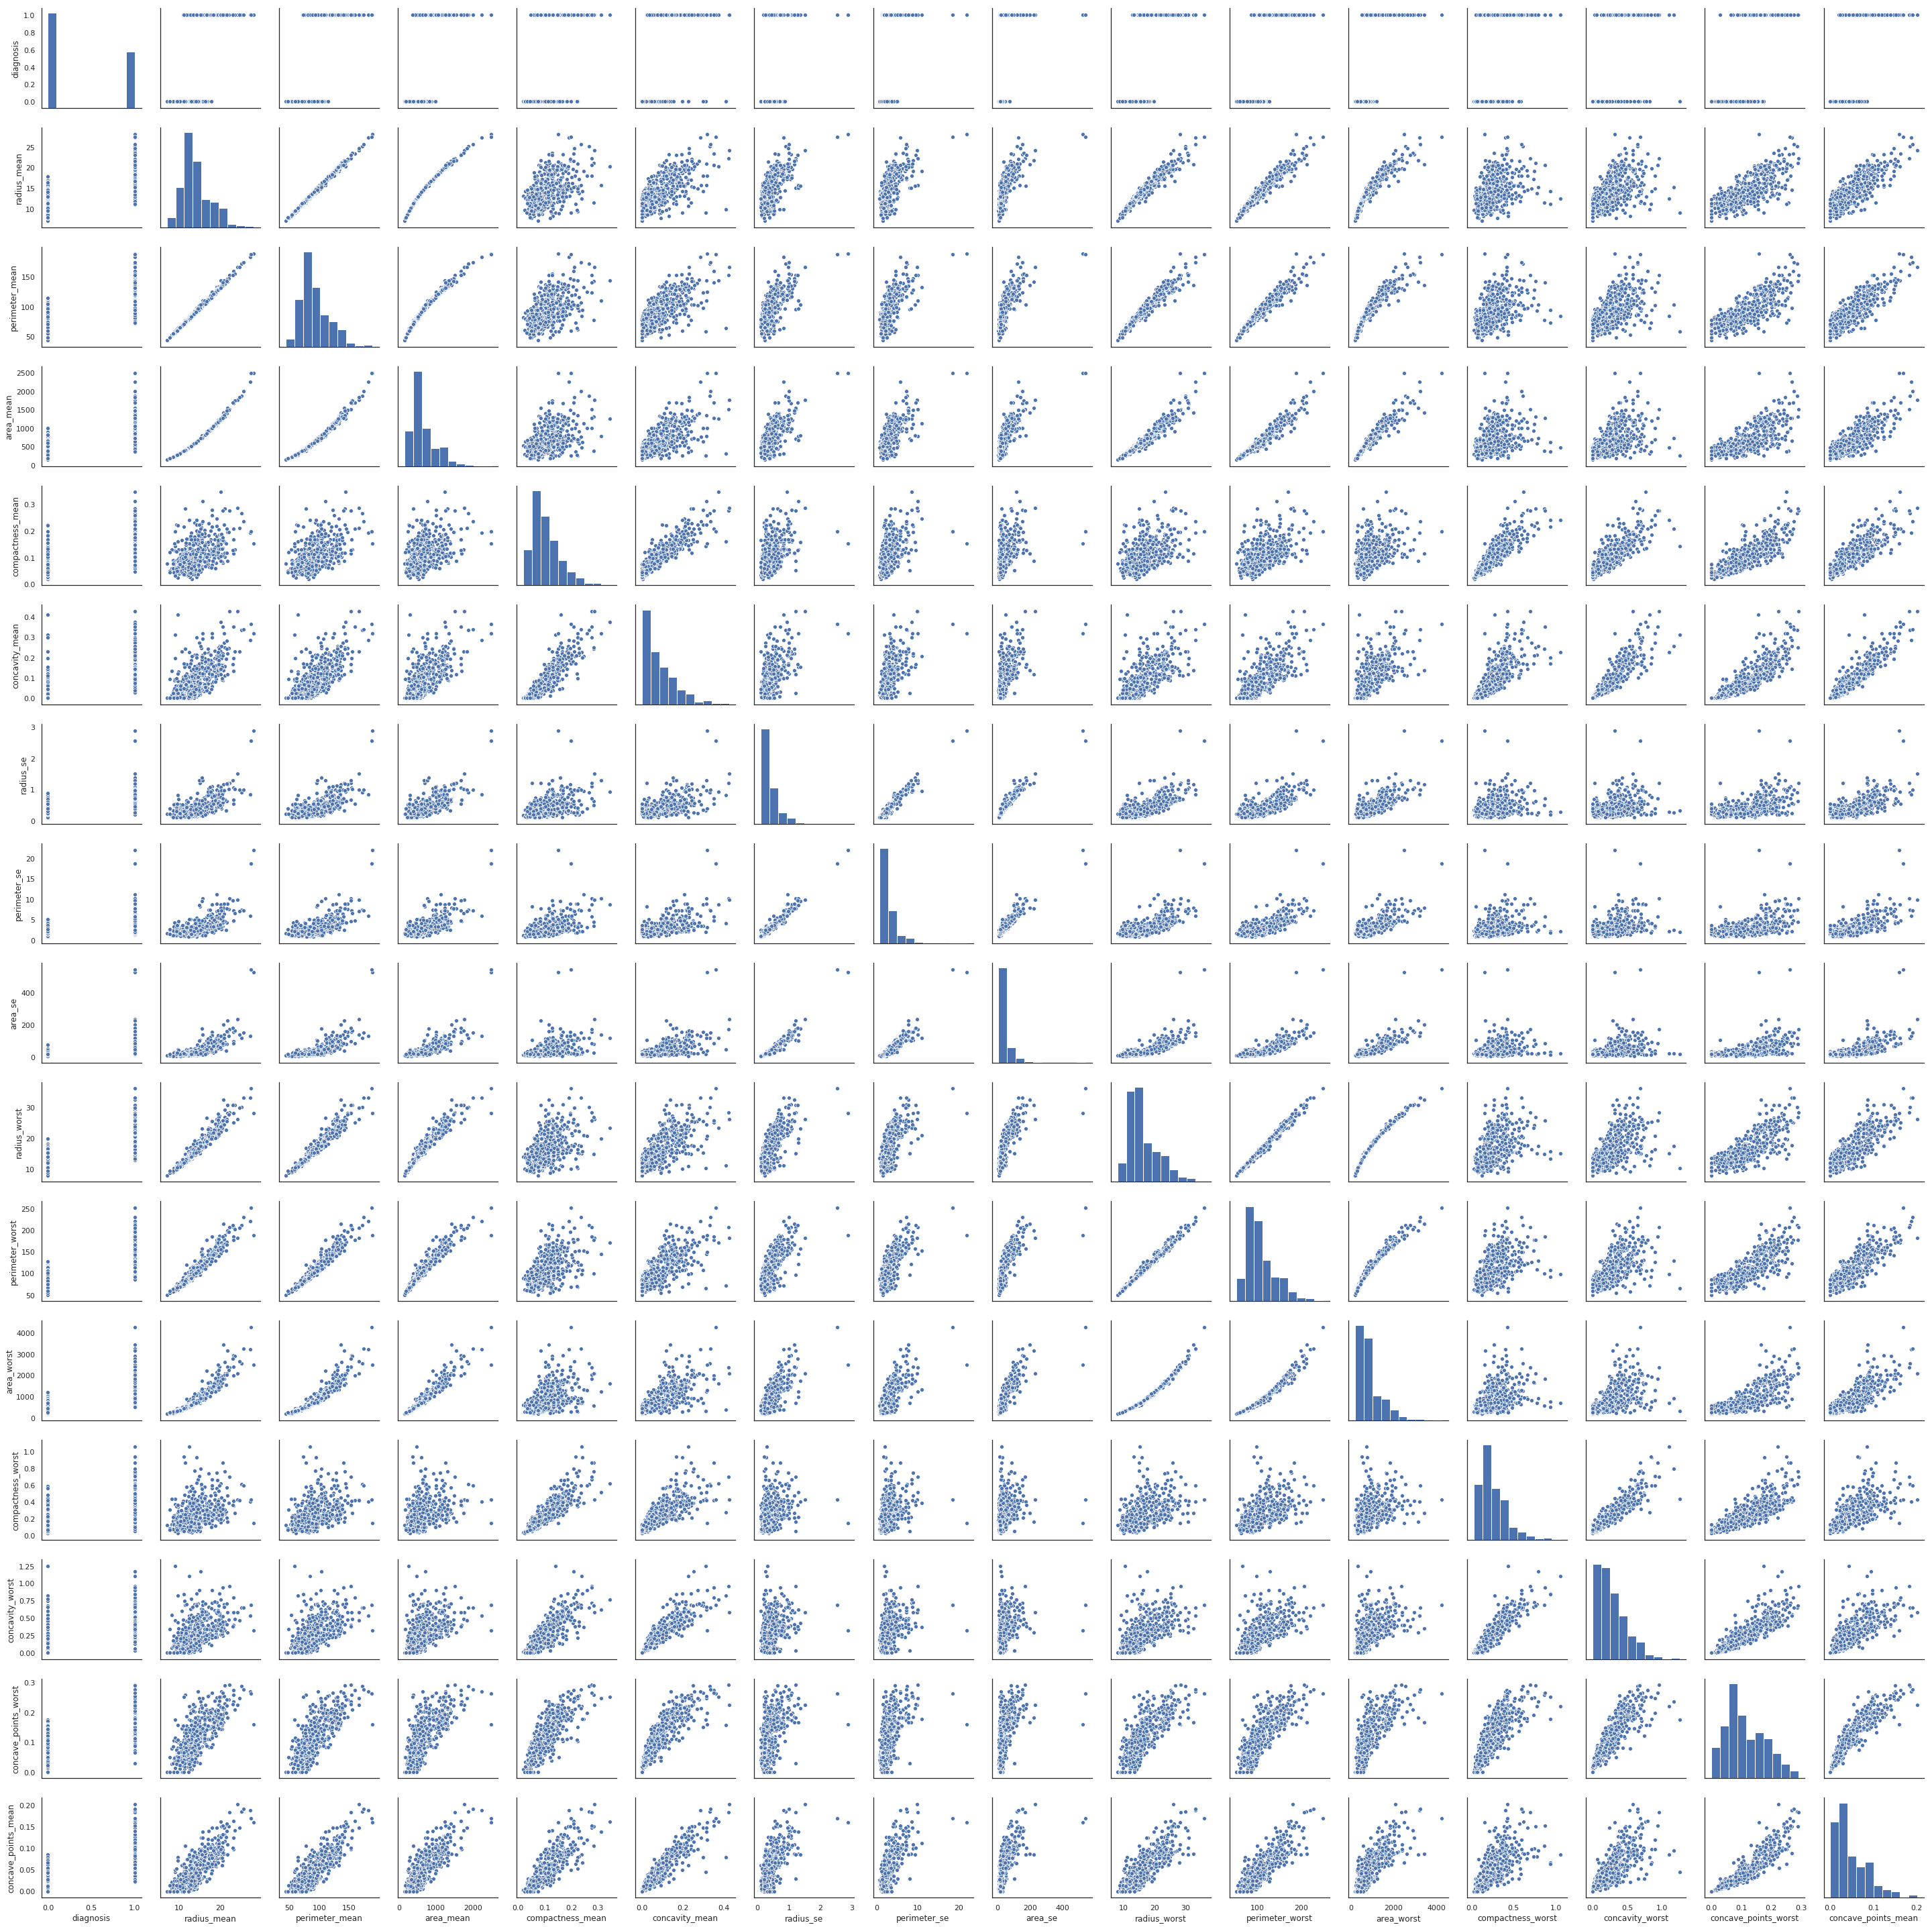

In [9]:
%config InlineBackend.figure_format = 'png' 

# т.к. pair plot тяжелый (и много фичей) то возьму только те переменные где корреляция больше 0.5 (по модулю)
column_list = corr['diagnosis'][corr['diagnosis'].abs() > 0.5].index

# видно что очень много переменных взаимосвязанны между собой (это не удивительно, т.к. например радиус и периметр связаны)
sns_plot = sns.pairplot(df[column_list])

#### 6. С помощью статистических методов проверить взаимосвязи между переменными.

In [10]:
formula = 'diagnosis ~ concave_points_worst + perimeter_worst + concave_points_mean + radius_worst + perimeter_mean + area_worst + radius_mean + area_mean + concavity_mean + concavity_worst + compactness_mean + compactness_worst + radius_se + perimeter_se + area_se + texture_worst + smoothness_worst + symmetry_worst + texture_mean + concave_points_se + smoothness_mean + symmetry_mean + fractal_dimension_worst + compactness_se + concavity_se + fractal_dimension_se + smoothness_se + fractal_dimension_mean + texture_se + symmetry_se  '
all_lm = smf.ols(formula, df).fit()
print(all_lm.summary())

                            OLS Regression Results                            
Dep. Variable:              diagnosis   R-squared:                       0.774
Model:                            OLS   Adj. R-squared:                  0.762
Method:                 Least Squares   F-statistic:                     61.53
Date:                Fri, 07 Dec 2018   Prob (F-statistic):          6.05e-153
Time:                        05:03:45   Log-Likelihood:                 29.650
No. Observations:                 569   AIC:                             2.699
Df Residuals:                     538   BIC:                             137.4
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

#### 7. Выбрать стратегию Feature Selection – сокращение размерности либо генерация новых переменных. Какой из этих двух подходов даст лучший результат при классификации?

In [11]:
def formula_build(features, target):
    return "{0} ~ {1}".format(target, ' + '.join(features))
feature_list = ['concave_points_worst', 'perimeter_worst', 'concave_points_mean', 'radius_worst', 'perimeter_mean', 'area_worst', 'radius_mean', 'area_mean', 'concavity_mean', 'concavity_worst', 'compactness_mean', 'compactness_worst', 'radius_se', 'perimeter_se', 'area_se', 'texture_worst', 'smoothness_worst', 'symmetry_worst', 'texture_mean', 'concave_points_se', 'smoothness_mean', 'symmetry_mean', 'fractal_dimension_worst', 'compactness_se', 'concavity_se', 'fractal_dimension_se', 'smoothness_se', 'fractal_dimension_mean', 'texture_se', 'symmetry_se']

#### 7.1. Пробуем сократить размерность (использую Backward selection)

In [12]:
def backward_selection(df, features, target):
    '''Данная функция реализует backward selection. Для этого пробует последовательно убирать фичи и смотреть на R^2 оценку
    если при итерации удаление любой фичи ведет а ухудшению R^2 то алгоритм прекращает работу и возвращает список фичей.
    '''
    selected_features = features
    for i in range(len(features)):
        rsq = smf.ols(formula_build(selected_features, target), df).fit().rsquared
        feature_drop_candidate = None
        for f_sel in range(len(selected_features)):
            cur_feat = selected_features[:f_sel] + selected_features[f_sel+1:]
            cur_rsq = smf.ols(formula_build(cur_feat, target), df).fit().rsquared
            if (rsq <= cur_rsq):
                rsq = cur_rsq
                feature_drop_candidate = f_sel
        if feature_drop_candidate is None:
            return selected_features
        selected_features = selected_features[:feature_drop_candidate] + selected_features[feature_drop_candidate+1:]
    return selected_features    

In [13]:
feature_list_bw = backward_selection(df, feature_list, 'diagnosis') # пробуем метод backward selection в качестве метрики оценки качества используем r^2

# Как видим, метод не сработал, количество эл-тов одинаково а это значит что если мы уберем любую фичу то у нас ухудшится оценка
print(len(feature_list) == len(feature_list_bw)) 

True


#### 7.2. Пробуем генерировать новые переменные

In [14]:
def pca_selection(df, features, target):
    rsq_base = smf.ols(formula_build(features, target), df).fit().rsquared
    rsq_base_idx = 0
    for f_len in range(1, len(features)):
        f_list = ["f{0}".format(i) for i in range(f_len)]
        new_fd = pd.DataFrame(PCA(n_components=f_len).fit_transform(df), columns=f_list)
        new_fd[target] = df[target]
        f_rsq = smf.ols(formula_build(f_list, target), new_fd).fit().rsquared
        if (f_rsq > rsq_base):
            rsq_base = f_rsq
            rsq_base_idx = f_len
    return rsq_base_idx, rsq_base

In [15]:
pca_count, pra_rsq = pca_selection(df, feature_list, 'diagnosis')
pca_f_list = ["f{0}".format(i) for i in range(pca_count)]
pca_df = pd.DataFrame(PCA(n_components=pca_count).fit_transform(df), columns=pca_f_list)
pca_df['diagnosis'] = df['diagnosis']
pca_lm = smf.ols(formula_build(pca_f_list, 'diagnosis'), pca_df).fit()
print("PCA features count:", pca_count)
pca_lm.summary()

PCA features count: 29


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              diagnosis   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 7.034e+12
Date:                Fri, 07 Dec 2018   Prob (F-statistic):               0.00
Time:                        05:03:46   Log-Likelihood:                 7190.7
No. Observations:                 569   AIC:                        -1.432e+04
Df Residuals:                     539   BIC:                        -1.419e+04
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3726   3.39e-08    1.1e+07      0.000       0.373       0.373
f0          1.539e-10   2.71e-16   5.68e+05      0.000    1.54e-10    1.54e-10
f1             0.0005   5.11e-11   1.05e+07      0.000       0.001       0.001
f2            -0.0002   3.96e-10  -5.73e+05      0.000      -0.000      -0.000
f3            -0.0017   1.29e-09   -1.3e+06      0.000      -0.002      -0.002
f4            -0.0225   4.58e-09  -4.92e+06      0.000      -0.023      -0.023
f5             0.0047   5.39e-09   8.71e+05      0.000       0.005       0.005
f6             0.0057   1.95e-08   2.94e+05      0.000       0.006       0.006
f7             0.0195   2.52e-08   7.75e+05      0.000       0.020       0.020
f8             0.0079   5.59e-08    1.4e+05      0.000       0.008       0.008
f9            -0.1628   8.54e-08  -1.91e+06      0.000      -0.163      -0.163
f10           -0.5946   1.13e-07  -5.25e+06      0.000      -0.595      -0.595
f11            0.6994   1.23e-07    5.7e+06      0.000       0.699       0.699
f12           -0.3578   2.18e-07  -1.64e+06      0.000      -0.358      -0.358
f13            0.0148   3.92e-07   3.78e+04      0.000       0.015       0.015
f14            0.0008   6.03e-07   1281.423      0.000       0.001       0.001
f15           -0.0279   7.37e-07  -3.79e+04      0.000      -0.028      -0.028
f16            0.0079   9.32e-07   8448.017      0.000       0.008       0.008
f17            0.0214   1.37e-06   1.56e+04      0.000       0.021       0.021
f18            0.0125   1.77e-06   7068.393      0.000       0.013       0.013
f19            0.0035   2.21e-06   1576.622      0.000       0.003       0.003
f20            0.0020    2.5e-06    811.763      0.000       0.002       0.002
f21            0.0041   2.66e-06   1543.798      0.000       0.004       0.004
f22            0.0047   3.87e-06   1202.145      0.000       0.005       0.005
f23           -0.0041    4.5e-06   -908.224      0.000      -0.004      -0.004
f24            0.0030   5.77e-06    513.129      0.000       0.003       0.003
f25           -0.0004   6.36e-06    -69.514      0.000      -0.000      -0.000
f26            0.0002   8.43e-06     26.258      0.000       0.000       0.000
f27           -0.0007    9.6e-06    -77.266      0.000      -0.001      -0.001
f28           -0.0010   1.79e-05    -56.046      0.000      -0.001      -0.001
==============================================================================
Omnibus:                      132.748   Durbin-Watson:                   1.957
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              908.564
Skew:                          -0.835   Prob(JB):                    5.10e-198
Kurtosis:                       8.961   Cond. No.                     6.61e+10
==============================================================================

W

#### 8. Провести стратегию Oversampling/Undersampling, проверить дает ли она улучшение результатов

In [16]:
# Дефолтные значения (для сравнения в будующем)
df_rsquared = smf.ols(formula_build(feature_list, 'diagnosis'), df).fit().rsquared
print("Origin rsquared:", df_rsquared)

Origin rsquared: 0.7743246526421793


In [17]:
# Oversampling
oversampled_features, oversampled_target = SMOTE().fit_resample(df[feature_list], df['diagnosis'])
oversampled_df = pd.DataFrame(oversampled_features, columns=feature_list)
oversampled_df['diagnosis'] = oversampled_target
oversampled_rsquared = smf.ols(formula_build(feature_list, 'diagnosis'), oversampled_df).fit().rsquared
print("Oversampled rsquared:", oversampled_rsquared)
print("Oversampled rsquared - Origin rsquared:", oversampled_rsquared - df_rsquared) # как видим стало чуть лучше

Oversampled rsquared: 0.781218352527528
Oversampled rsquared - Origin rsquared: 0.006893699885348714


In [18]:
# Undersampling
undersampled_features, undersampled_target = NearMiss(version=1).fit_resample(df[feature_list], df['diagnosis'])
undersampled_df = pd.DataFrame(undersampled_features, columns=feature_list)
undersampled_df['diagnosis'] = undersampled_target
undersampled_rsquared = smf.ols(formula_build(feature_list, 'diagnosis'), undersampled_df).fit().rsquared
print("Undersampled rsquared:", undersampled_rsquared)
print("Undersampled rsquared - Origin rsquared:", undersampled_rsquared - df_rsquared) # как видим стало чуть хуже

Undersampled rsquared: 0.7729161412707235
Undersampled rsquared - Origin rsquared: -0.0014085113714558117


#### 9. Сделать кросс-валидацию данных с использованием подхода K-fold (n_folds=10).

In [19]:
# буду использовать ее позже
kf = KFold(n_splits=10)
for train_index, test_index in kf.split(df):
    print('test len:', len(test_index), 'train len: ',  len(train_index))

test len: 57 train len:  512
test len: 57 train len:  512
test len: 57 train len:  512
test len: 57 train len:  512
test len: 57 train len:  512
test len: 57 train len:  512
test len: 57 train len:  512
test len: 57 train len:  512
test len: 57 train len:  512
test len: 56 train len:  513


#### 10. Рассчитать Feature Selection для выбранных переменных. 

In [20]:
# буду использовать Хи квадрат
pca_count = 28
fs_list = ["f{0}".format(i) for i in range(pca_count)]
fs_df = pd.DataFrame(SelectKBest(score_func=chi2, k=pca_count).fit_transform(df[feature_list], df['diagnosis']), columns=fs_list)
fs_df['diagnosis'] = df['diagnosis']
fs_lm = smf.ols(formula_build(fs_list, 'diagnosis'), fs_df).fit()
fs_lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              diagnosis   R-squared:                       0.774
Model:                            OLS   Adj. R-squared:                  0.762
Method:                 Least Squares   F-statistic:                     66.11
Date:                Fri, 07 Dec 2018   Prob (F-statistic):          1.11e-154
Time:                        05:03:46   Log-Likelihood:                 29.445
No. Observations:                 569   AIC:                           -0.8901
Df Residuals:                     540   BIC:                             125.1
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.0050      0.301     -6.670      0.000      -2.596      -1.414
f0             0.4613      0.912      0.506      0.613      -1.330       2.253
f1            -0.0028      0.006     -0.484      0.629      -0.014       0.009
f2             2.0954      1.972      1.063      0.288      -1.778       5.969
f3             0.1932      0.058      3.343      0.001       0.080       0.307
f4             0.0241      0.025      0.972      0.331      -0.025       0.073
f5            -0.0010      0.000     -3.127      0.002      -0.002      -0.000
f6            -0.2170      0.173     -1.255      0.210      -0.556       0.123
f7             0.0003      0.001      0.586      0.558      -0.001       0.001
f8             1.4114      1.042      1.355      0.176      -0.635       3.458
f9             0.3876      0.266      1.456      0.146      -0.135       0.911
f10           -4.1674      1.139     -3.660      0.000      -6.404      -1.931
f11            0.0407      0.361      0.113      0.910      -0.669       0.750
f12            0.4420      0.308      1.433      0.152      -0.164       1.048
f13           -0.0189      0.040     -0.471      0.638      -0.098       0.060
f14           -0.0010      0.001     -0.763      0.446      -0.004       0.002
f15            0.0059      0.007      0.895      0.371      -0.007       0.019
f16            0.3723      1.406      0.265      0.791      -2.389       3.134
f17            0.7928      0.317      2.498      0.013       0.169       1.416
f18            0.0057      0.008      0.740      0.459      -0.009       0.021
f19           10.4579      5.421      1.929      0.054      -0.190      21.106
f20            0.2543      1.969      0.129      0.897      -3.614       4.122
f21           -0.0602      0.694     -0.087      0.931      -1.423       1.302
f22            4.1559      1.982      2.096      0.037       0.262       8.050
f23            0.2392      2.145      0.112      0.911      -3.974       4.452
f24           -3.6089      1.292     -2.792      0.005      -6.148      -1.070
f25           -6.7864     11.568     -0.587      0.558     -29.510      15.937
f26           16.8247      6.429      2.617      0.009       4.196      29.454
f27            0.0013      0.034      0.038      0.970      -0.066       0.069
==============================================================================
Omnibus:                       31.174   Durbin-Watson:                   1.787
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               34.794
Skew:                           0.591   Prob(JB):                     2.78e-08
Kurtosis:                       3.267   Cond. No.                     1.53e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is

#### 11. Решить задачу бинарной классификации и предсказать переменную ”Diagnosis ” протестировав как минимум 2 алгоритма. Использовать те алгоритмы, которые позволяют предсказать вероятность класса (proba). Рассчитать и вывести вероятность каждого класса. 
#### 12. Проверить качество классификации с использованием следующих метрик: Accuracy, F1-Score, Precision, Recall

In [21]:
def test_method(method):
    metrics_feature = ['Fold', 'Accuracy', 'F1-Score', 'Precision', 'Recall']
    metrics_df = pd.DataFrame(columns=metrics_feature)
    kf = KFold(n_splits=10)
    fold = 0
    for train_index, test_index in kf.split(fs_df):
        train_df = fs_df.iloc[train_index]
        test_df = fs_df.iloc[test_index]
        clf = method.fit(train_df[fs_list], train_df['diagnosis'])
        test_predicted = clf.predict(test_df[fs_list])
        acc = metrics.accuracy_score(test_df['diagnosis'], test_predicted)
        f1 = metrics.f1_score(test_df['diagnosis'], test_predicted)
        precision = metrics.precision_score(test_df['diagnosis'], test_predicted)
        recall = metrics.recall_score(test_df['diagnosis'], test_predicted)
        metrics_df.loc[fold] = [fold + 1, acc, f1, precision, recall]
        fold += 1
    return metrics_df

#### GaussianNB

In [22]:
print("GaussianNB")
test_method(GaussianNB())

GaussianNB


,Fold,Accuracy,F1-Score,Precision,Recall
0,1.0,0.894737,0.930233,1.000000,0.869565
1,2.0,0.859649,0.809524,0.850000,0.772727
2,3.0,0.912281,0.883721,0.863636,0.904762
3,4.0,0.929825,0.923077,1.000000,0.857143
4,5.0,0.947368,0.945455,0.962963,0.928571
5,6.0,0.964912,0.916667,0.916667,0.916667
6,7.0,0.982456,0.967742,1.000000,0.937500
7,8.0,0.964912,0.923077,0.923077,0.923077
8,9.0,0.947368,0.896552,0.812500,1.000000
9,10.0,0.964286,0.916667,1.000000,0.846154


#### RandomForestClassifier

In [23]:
print("RandomForestClassifier")
test_method(RandomForestClassifier())

RandomForestClassifier


/home/mbadin/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


,Fold,Accuracy,F1-Score,Precision,Recall
0,1.0,0.877193,0.917647,1.000000,0.847826
1,2.0,0.929825,0.904762,0.950000,0.863636
2,3.0,0.929825,0.904762,0.904762,0.904762
3,4.0,0.982456,0.981818,1.000000,0.964286
4,5.0,1.000000,1.000000,1.000000,1.000000
5,6.0,0.982456,0.956522,1.000000,0.916667
6,7.0,0.947368,0.909091,0.882353,0.937500
7,8.0,0.964912,0.928571,0.866667,1.000000
8,9.0,0.964912,0.928571,0.866667,1.000000
9,10.0,0.964286,0.923077,0.923077,0.923077
